In [151]:
import numpy as np
import matplotlib.pyplot as plt
import pickle


from helpers.physics_functions import bkg_fit_cubic, bkg_fit_septic, bkg_fit_quintic, get_bins, select_top_events_fold, curve_fit_m_inv, calc_significance, get_errors_bkg_fit_ratio, calculate_test_statistic
from helpers.evaluation import get_median_percentiles
from helpers.plotting import newplot, hist_with_outline, hist_with_errors, function_with_band, stamp
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Try to load LaTeX
latex_flag = False
np.seterr(divide='ignore')

# try:
#     plt.rc('text', usetex=True)
#     plt.rc('font', family='serif')
#     fig, ax = newplot("full", use_tex = True)
#     print("Loaded LaTeX")
#     latex_flag = True
# except:
#     print("Could not load LaTeX")
#     latex_flag = False  
# latex_flag = False

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

This notebook should be run twice:

1. `train_samesign = False` gives the "standard" results. i.e. we run the studies on the OS samples
2. `train_samesign = True` comes from running the Ml study on the SS samples.

**CAUTION**: for the histograms, we are truly showing the significance as $\frac{S}{\sqrt{B+{\sigma_B}^2}}$, i.e. we are accounting for the background error. For the ROC curves, this error is *NOT* being taken into account (it's not clear to me that we want this background error when we are just citing the background yield for the FPR)

In [152]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file) 

# pickles contain all the results from the BDT training
pickle_save_dir_prefix = "/global/cfs/cdirs/m3246/rmastand/dimuonAD/pickles/mix_2"
train_samesign = False

working_dir = f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/logit_08_22/"


# Define outut folder for plot data
plot_data_dir = f"plot_data/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 100
n_folds = 5
particle_type = "upsilon_iso"
particle_id = "upsilon"
ONE_SIDED = True


# Needed for Classical Studies
jet_id = "nojet"
config_id = "CATHODE_8"
project_id = "lowmass"
flow_id = "mix_2"

all_TPR = {}
all_SIC = {}
all_FPR = {}
all_ROC = {}

In [ ]:
num_bins_SR = 16 # 16, 12, 8

pseudo_e_to_plot = 0 # this plots the actual data (not a boostrapped version)
fit_type = "septic" # "cubic", "quintic", septic
if fit_type == "cubic": fit_function = bkg_fit_cubic
if fit_type == "quintic": fit_function = bkg_fit_quintic
if fit_type == "septic": fit_function = bkg_fit_septic


In [154]:
SB_left = float(workflow[particle_id]["SB_left"])
SR_left = float(workflow[particle_id]["SR_left"])
SR_right = float(workflow[particle_id]["SR_right"])
SB_right = float(workflow[particle_id]["SB_right"])


# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "_samesign"
else:
    train_data_id = ""

# train on opp sign means alt test set is samesign
if train_data_id == "": 
    alt_test_data_id = "_samesign"
    train_data_id_title = "_oppsign"
elif train_data_id == "_samesign": 
    alt_test_data_id = ""
    train_data_id_title = "_samesign"

data_prefix = f"{project_id}_{particle_type}{train_data_id}_{jet_id}"

# Save the SR and SB regions
SR = (SR_left, SR_right)
SB = (SB_left, SB_right)
with open(f"{plot_data_dir}{data_prefix}_SR_SB.pickle", "wb") as file:
    pickle.dump((SR, SB), file)

# Load in the original data

In [155]:
# load in the data corresponding to the train id
# we actually want the "test band" here -- train is just for flow
with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{train_data_id}_{jet_id}_test_band_data", "rb") as infile: 
    test_data_dict = pickle.load(infile)

with open(f"{working_dir}/models/{project_id}_{particle_type}{train_data_id}_{jet_id}/{flow_id}/{config_id}/seed1/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    
    feature_set = [x.strip() for x in configs.split("'")][1::2]

print(f"Feature Set: {feature_set}")

Feature Set: ['dimu_pt', 'mu0_ip3d', 'mu1_ip3d', 'dimu_mass']


## Load in the BDT results

In [156]:
# if train_samesign = False, this loads in the OS test data
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_test_data_splits_{fit_type}_{num_bins_SR}", "rb") as ifile:
    all_test_data_splits = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_scores_splits_{fit_type}_{num_bins_SR}", "rb") as ifile:
    all_scores_splits = pickle.load(ifile)
# if train_samesign = False, this loads in the SS test data, OS high-stats data, and OS flow samples
# if train_samesign = True, this loads in the OS test data, SS high-stats data, and SS flow samples
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_data_splits_{fit_type}_{num_bins_SR}", "rb") as ifile:
    all_alt_data_splits = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_scores_splits_{fit_type}_{num_bins_SR}", "rb") as ifile:
    all_alt_scores_splits = pickle.load(ifile)
with open(f"{working_dir}/processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)

/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Plot histograms for a small number of FPR thresholds

In [157]:
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]

# Save the FPR thresholds
with open(f"{plot_data_dir}{data_prefix}_fpr_thresholds", "wb") as ofile:
    pickle.dump(fpr_thresholds, ofile)

# determine score cutoffs for each pseudoexperiments
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        
        for threshold in fpr_thresholds:
            
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff


In [158]:
def plot_upsilon_resonances(ax):

    
    # plot the upsilon resonances
    ax.axvline(9.460, color="black", linestyle="--", alpha=0.15)
    ax.text(9.460 * 0.995, 1e4, r"$\Upsilon(1S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.023, color="black", linestyle="--", alpha=0.15)
    ax.text(10.023 * 0.995, 1e4, r"$\Upsilon(2S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.355, color="black", linestyle="--", alpha=0.15)
    ax.text(10.355 * 0.995, 1e4, r"$\Upsilon(3S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.580, color="black", linestyle="--", alpha=0.15)
    ax.text(10.580 * 0.995, 1e4, r"$\Upsilon(4S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    # ax.axvline(11.020, color="black", linestyle="--", alpha=0.15)
    # ax.text(11.020 * 0.995, 1e4, r"$\Upsilon(5S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)

In [159]:
def plot_histograms_with_fits(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, n_folds= 5, take_score_avg=True,):
    

    save_data = {}
    save_data["fpr_thresholds"] = fpr_thresholds
    save_data["fit_type"] = fit_type
    save_data["num_bins_SR"] = num_bins_SR
    save_data["popts"] = []
    save_data["pcovs"] = []
    save_data["significances"] = []
    save_data["filtered_masses"] = []
    save_data["y_vals"] = []


    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)




    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_masses = []

        # for each fold, select the events that meet the fpr threshold
        for i_fold in range(n_folds):
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
            loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs_by_fold[i_fold][threshold],plot_bins_left, plot_bins_right, plot_bins_SR)
            filtered_masses.append(loc_filtered_masses)
        # consolidate the fold information
        filtered_masses = np.concatenate(filtered_masses)

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)

    
        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
        function_with_band(ax, fit_function, [SB_left, SB_right], popt, pcov, color = f"C{t}")

# def function_with_band(ax, f, range, params, pcov = None, color = "purple", alpha_line = 0.75, alpha_band = 0.25, lw = 3,  **kwargs):


        # calculate significance of bump
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, ONE_SIDED)
        q0 = calculate_test_statistic(filtered_masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov)

        # test_statistic(masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov, ONE_SIDED = True, verbose = False)

        y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
        B_error = np.sqrt(np.sum(y_err**2))
        S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
        total_events = len(filtered_masses)




        label_string = str(round(100*threshold, 2))+"% FPR: "+str(total_events)+" events,  $Z_0$: "+str(round(np.sqrt(q0),2))

        # hist_with_errors(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        # hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")


        save_data["popts"].append(popt)
        save_data["pcovs"].append(pcov)
        save_data["significances"].append(np.sqrt(q0))
        save_data["filtered_masses"].append(filtered_masses)
        save_data["y_vals"].append(y_vals)



    line1 = f"{num_bins_SR -1 } Bins in SR"
    line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
    line3 = r"Muon Iso_04 $\geq$ 0.55"
    line4 = r"~6% of Original Data"

    starting_x = 0.05
    starting_y = 0.8
    delta_y = 0.04
    text_alpha = 0.75
    ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)


    legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"
    plt.legend(loc = (0.465, 0.575), fontsize = 14, title = legend_title, title_fontsize = 16)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    plt.yscale("log")
    # plt.ylim(0.5, 1e3)
    plt.ylim(0.5, 1e5)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

    plot_upsilon_resonances(ax)
    

    # # Vertical Black Lines at boundaries of SR
    # plt.axvline(SR_left, color = "black", linestyle = "--", lw = 2)
    # plt.axvline(SR_right, color = "black", linestyle = "--", lw = 2)


    # plt.title(title, fontsize = 24)
    return save_data
    


<>:108: SyntaxWarning: invalid escape sequence '\m'
<>:108: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1591802/3307863516.py:108: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)


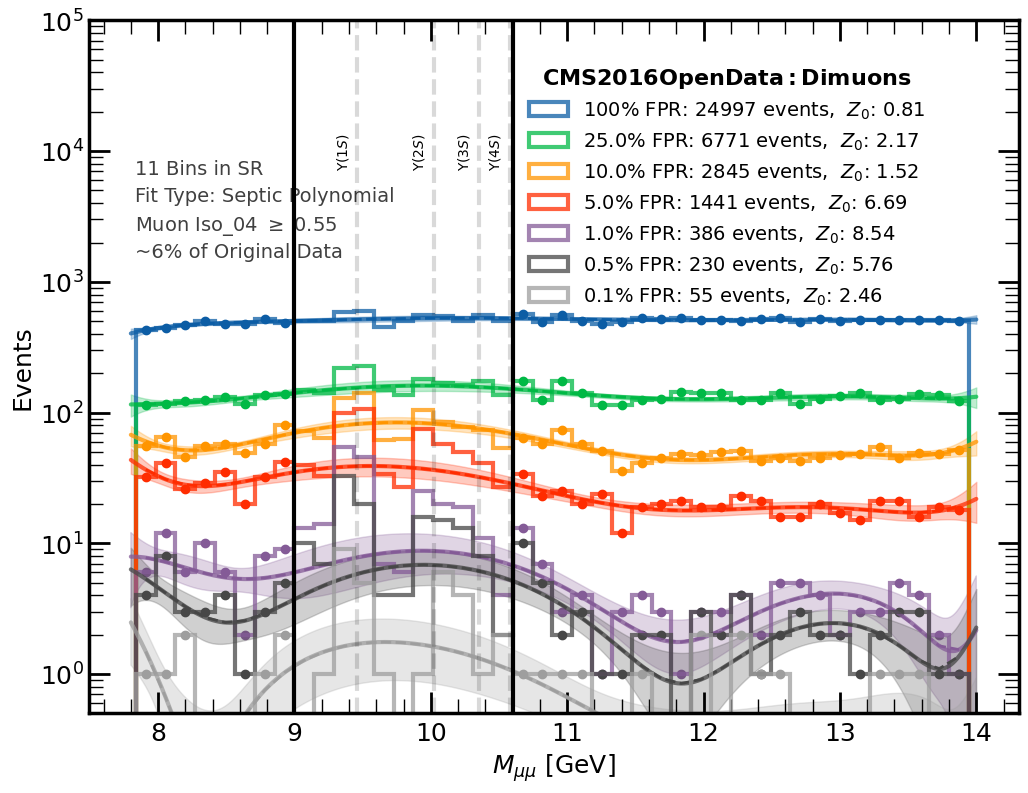

In [160]:

"""
PLOT HISTOGRAM ON SMALL TEST SET
"""
save_data = plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"{particle_type}{train_data_id_title} (trained on {train_data_id_title})\n", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_histogram_data_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)


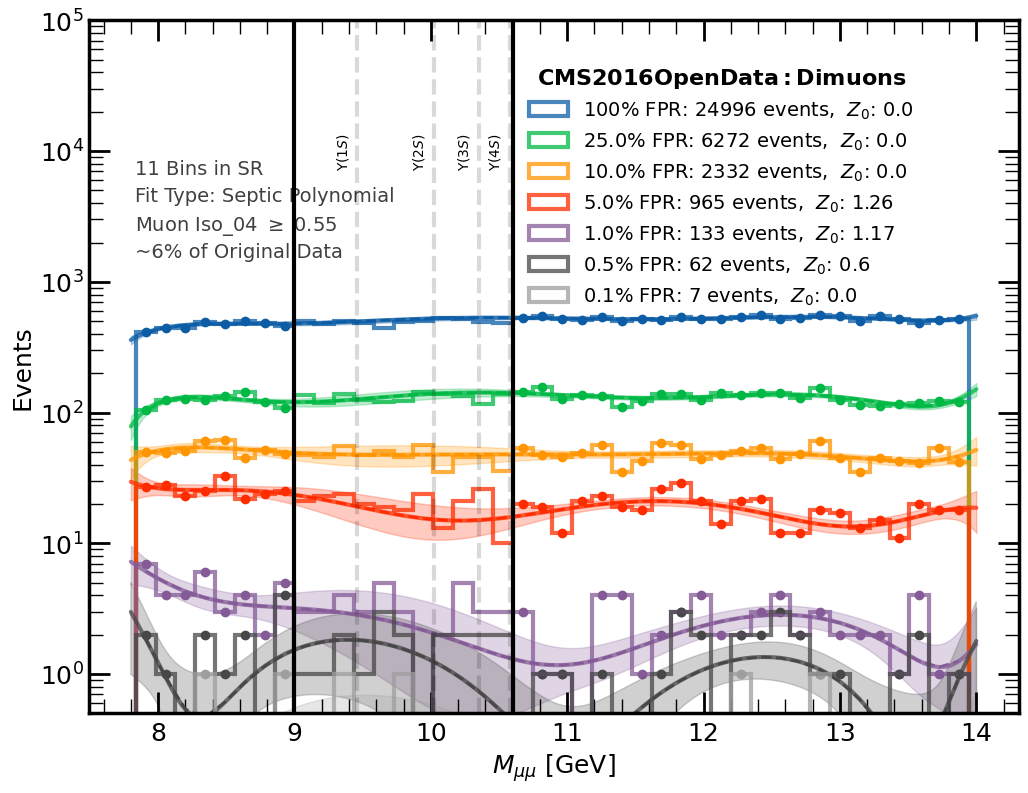

In [161]:


"""
PLOT HISTOGRAM ON ALTERNATIVE TEST SET
"""
save_data = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type, f"{particle_type}{alt_test_data_id} (trained on {train_data_id_title})\n",SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_histogram_data_alt_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)


In [162]:
"""
PLOT HISTOGRAM ON ROC TEST DATA
"""
# this plot won't be shown in the main body -- this is just the high-stats set that is used to create the ROC curve

#plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_data"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_data"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats data _oppsign (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)



'\nPLOT HISTOGRAM ON ROC TEST DATA\n'

{'fpr_thresholds': [1, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001],
 'fit_type': 'septic',
 'num_bins_SR': 12,
 'popts': [array([-1.06134240e+07,  7.02130257e+06, -1.97843173e+06,  3.07796677e+05,
         -2.85497553e+04,  1.57872829e+03, -4.81901267e+01,  6.26438077e-01]),
  array([-4.52367187e+06,  2.99628807e+06, -8.44590154e+05,  1.31337259e+05,
         -1.21678949e+04,  6.71654317e+02, -2.04550513e+01,  2.65180084e-01]),
  array([-6.82598098e+05,  4.77066462e+05, -1.41732560e+05,  2.31982960e+04,
         -2.25828888e+03,  1.30718595e+02, -4.16562131e+00,  5.63814695e-02]),
  array([-5.18253814e+05,  3.40435087e+05, -9.51254283e+04,  1.46542429e+04,
         -1.34351176e+03,  7.32687451e+01, -2.19985084e+00,  2.80428099e-02]),
  array([ 1.09838993e+05, -6.61967823e+04,  1.69532966e+04, -2.39331875e+03,
          2.01372872e+02, -1.01116214e+01,  2.80939892e-01, -3.33606310e-03]),
  array([ 3.82752539e+04, -2.24360978e+04,  5.52158563e+03, -7.37081254e+02,
          5.73797728e+01, -2.5

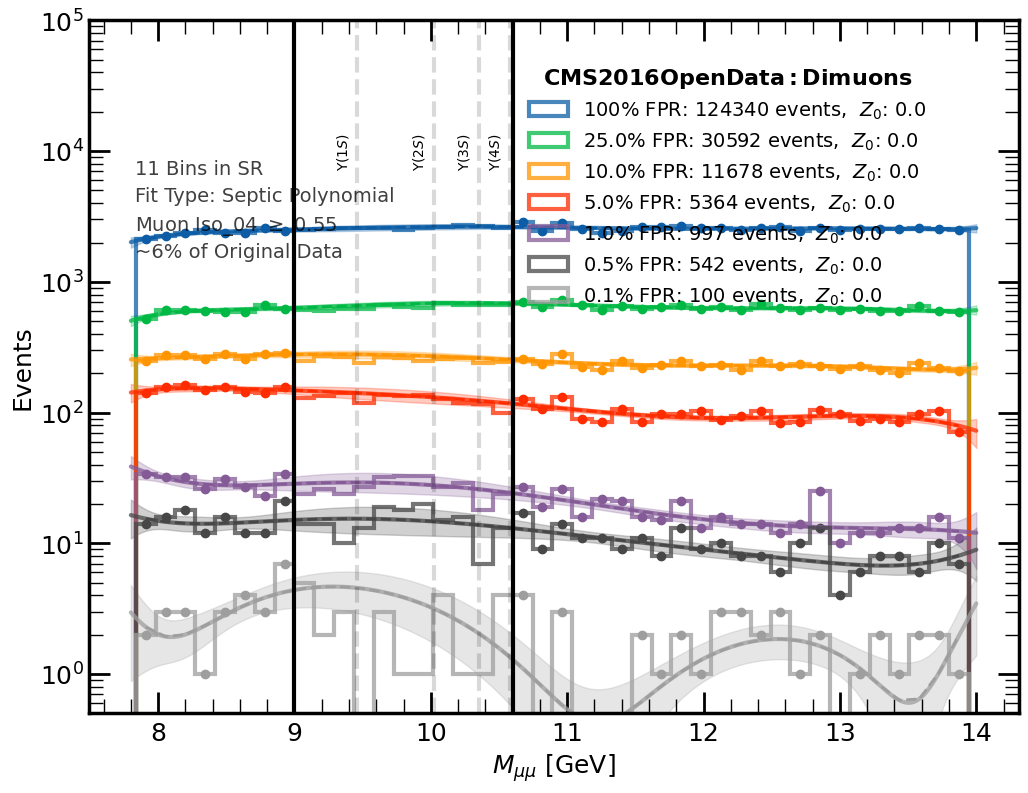

In [163]:
"""
PLOT HISTOGRAM ON FLOW SAMPLES
"""
plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


# Classical Studies

In [164]:
from helpers.plotting import feature_bins


def plot_feature_cuts(feature, fpr_thresholds, test_data_dict, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, flip = False):
    """
    Plot the feature cuts for the given data, scores, and score cutoffs.

    Parameters
    ----------
    feature : str
        The feature to plot the cuts for.
    fpr_thresholds : list
        The list of FPR thresholds to plot.
    test_data_dict : dict
        The dictionary of test data.
    mass_scalar : sklearn.preprocessing.StandardScaler
        The mass scaler.
    fit_type : str
        The type of fit to use for the background.
    title : str
        The title of the plot.
    SB_left : float
        The left side of the sideband.
    SR_left : float
        The left side of the signal region.
    SR_right : float
        The right side of the signal region.
    SB_right : float
        The right side of the sideband.
    """

        
    save_data = {}
    save_data["fpr_thresholds"] = fpr_thresholds
    save_data["fit_type"] = fit_type
    save_data["num_bins_SR"] = num_bins_SR
    save_data["popts"] = []
    save_data["pcovs"] = []
    save_data["significances"] = []
    save_data["filtered_masses"] = []
    save_data["y_vals"] = []

    # Unpack the data dictionary to extract the feature of interest 
    feature_SBL = test_data_dict["SBL"]["s_inj_data"][feature]
    feature_SR = test_data_dict["SR"]["s_inj_data"][feature]
    feature_SBH = test_data_dict["SBH"]["s_inj_data"][feature]

    if flip:
        feature_SBL = -feature_SBL
        feature_SR = -feature_SR
        feature_SBH = -feature_SBH

    # Unpack the data dictionary to extract the dimuon mass spectrum
    mass_SBL = mass_scalar.inverse_transform(np.array(test_data_dict["SBL"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
    mass_SR = mass_scalar.inverse_transform(np.array(test_data_dict["SR"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
    mass_SBH = mass_scalar.inverse_transform(np.array(test_data_dict["SBH"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))

    # Get a list of all possible cuts for the feature
    feature_cut_points = np.linspace(np.min(feature_SBL), np.max(feature_SBH), 1000)

    # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut))
        num_in_SR.append(np.sum(feature_SR >= cut))
        num_in_SBH.append(np.sum(feature_SBH >= cut))


        # @RADHA: I am estimating the FPR of each cut by the amount the sideband gets reduced. I cannot parse how you have done it above.
        # FPR is the combination of SBH and SBL
        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))

    
    # Set up fit types
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

    fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}


    # fig, ax = newplot("full", aspect_ratio = 1.5)
    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
    for t, threshold in enumerate(fpr_thresholds):


        # Use interpolation to find the cut point that gives the desired FPR
        best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

        # Make the cuts to both the feature and the mass
        feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
        feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
        feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

        mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
        mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
        mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

        # Concatenate to get the full mass spectrum
        filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
        

        # get the fit function to SB background
        # popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv_CLASSICAL(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_SR, plot_bins_right, plot_centers_all)
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)
        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    

        # calculate significance of bump
                # calculate significance of bump
        if ONE_SIDED:
            num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, ONE_SIDED)
            q0 = calculate_test_statistic(filtered_masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov)


            y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
            B_error = np.sqrt(np.sum(y_err**2))
            S_over_B = num_S_expected_in_SR/num_B_expected_in_SR

            

        label_string = str(round(100*threshold, 2))+"% FPR: "+str(len(feature_SBL_cut)+len(feature_SR_cut)+len(feature_SBH_cut))+" events,  $Z_0$: "+str(round(np.sqrt(q0),2))


        hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string, alpha_1 = 0.1, alpha_2 = 0.5)
        # plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")


        save_data["popts"].append(popt)
        save_data["pcovs"].append(pcov)
        save_data["significances"].append(np.sqrt(q0))
        save_data["filtered_masses"].append(filtered_masses)
        save_data["y_vals"].append(y_vals)

    line1 = f"{num_bins_SR -1 } Bins in SR"
    line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
    line3 = r"Muon Iso_04 $\geq$ 0.55"
    line4 = r"~6% of Original Data"

    starting_x = 0.475
    starting_y = 0.45
    delta_y = 0.04
    text_alpha = 0.75
    ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)


    legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$: "+feature
    plt.legend(loc = (0.465, 0.575), fontsize = 14, title = legend_title, title_fontsize = 16)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    # plt.yscale("log")
    plt.ylim(0.5, 1e3)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

    plot_upsilon_resonances(ax)

    return save_data


<>:165: SyntaxWarning: invalid escape sequence '\m'
<>:165: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1591802/3971992411.py:165: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)


dimu_pt


mu0_ip3d
mu1_ip3d


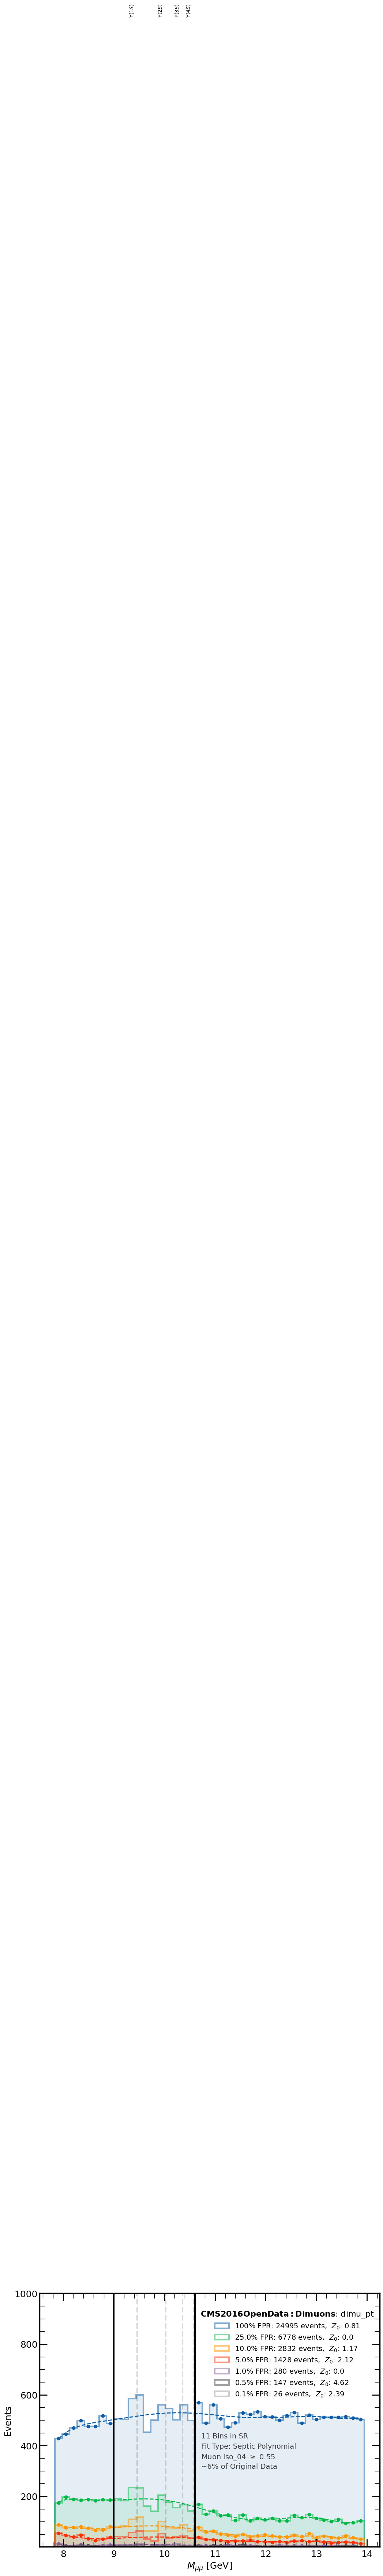

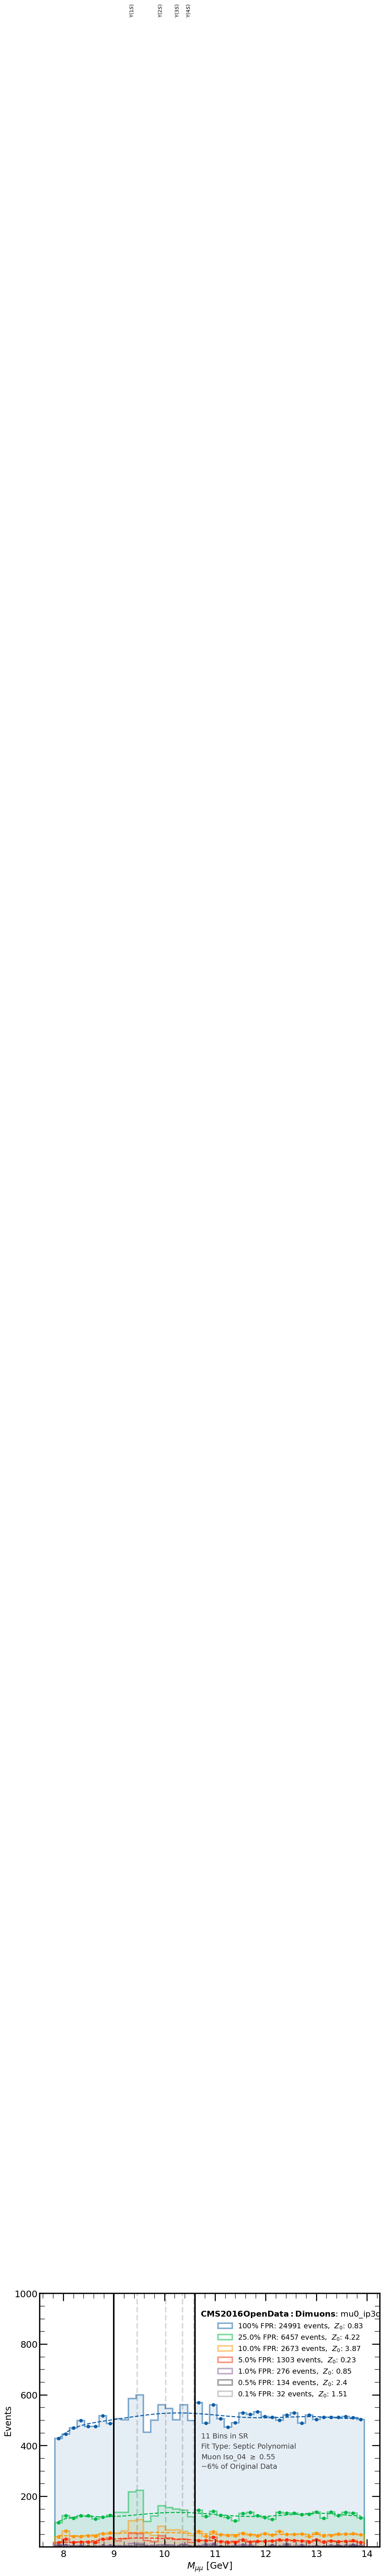

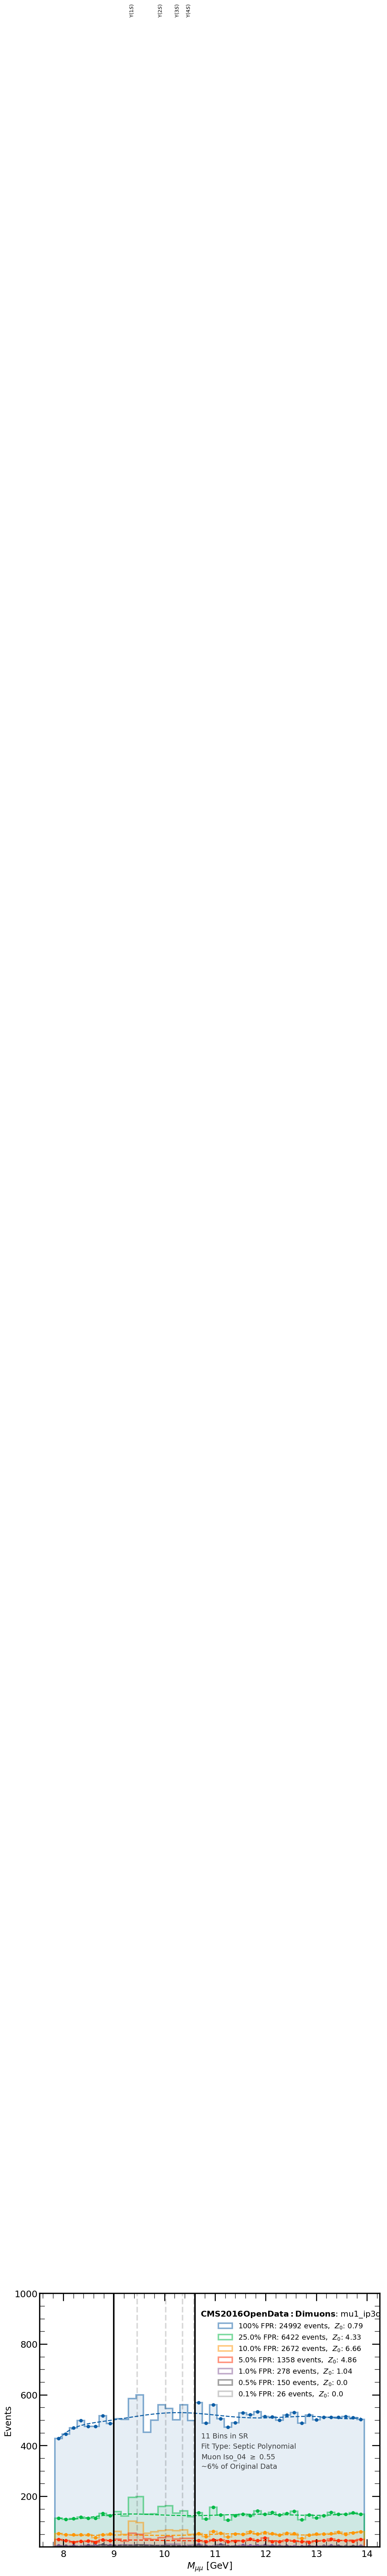

In [165]:
flip_features = [False, True, True]
for feature in feature_set[:-1]:
    print(feature)
    save_data =  plot_feature_cuts(feature, fpr_thresholds, test_data_dict, scaler, fit_type, f"{particle_type}{train_data_id_title} ({feature} on {train_data_id_title})", SB_left, SR_left, SR_right, SB_right, flip = flip_features[feature_set.index(feature)])
    with open(f"{plot_data_dir}{data_prefix}_feature_cut_data_{feature}_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
        pickle.dump(save_data, ofile)


In [166]:


"""
CALCULATE THE ROC CURVES
"""

# determine fpr thresholds as before
# yes this is repeated code
fpr_thresholds_finegrained = np.logspace(0, -4, 25)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff

        
def get_classifier_metrics_high_stats(dataset_by_pseudo_e, scores_by_pseudo_e, score_cutoffs):
            
    S_yield, B_yield = np.empty((fpr_thresholds_finegrained.shape[0], num_pseudoexperiments)), np.empty((fpr_thresholds_finegrained.shape[0], num_pseudoexperiments))
    significances = np.empty((fpr_thresholds_finegrained.shape[0], num_pseudoexperiments))


    for pseudo_e in range(num_pseudoexperiments):

        print(f"On pseudo experiment {pseudo_e+1}...")
        for t, threshold in enumerate(fpr_thresholds_finegrained):

            filtered_masses_bs = []

            for i_fold in range(n_folds):
                loc_true_masses_bs = scaler.inverse_transform(np.array(dataset_by_pseudo_e[pseudo_e][i_fold][:,-1]).reshape(-1,1))
                loc_scores_bs = scores_by_pseudo_e[pseudo_e][i_fold]
                # filter top event based on score cutoff
                loc_filtered_masses_bs, _, _, _ = select_top_events_fold(loc_true_masses_bs, loc_scores_bs, score_cutoffs[pseudo_e][i_fold][threshold], plot_bins_left, plot_bins_right, plot_bins_SR)
                filtered_masses_bs.append(loc_filtered_masses_bs)

            filtered_masses_bs = np.concatenate(filtered_masses_bs)
            # get the fit function to SB background
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses_bs, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)

            # calculate significance of bump
            if ONE_SIDED:
                q0 = calculate_test_statistic(filtered_masses_bs, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov)
                significance = np.sqrt(q0)

                significances[t, pseudo_e] = significance

        
    
    return significances



In [167]:
from helpers.plotting import feature_bins


def feature_cut_ROCS(feature, test_data_dict, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, flip = False, index = 0):
    """
    Plot the feature cuts for the given data, scores, and score cutoffs.

    Parameters
    ----------
    feature : str
        The feature to plot the cuts for.
    fpr_thresholds : list
        The list of FPR thresholds to plot.
    test_data_dict : dict
        The dictionary of test data.
    mass_scalar : sklearn.preprocessing.StandardScaler
        The mass scaler.
    fit_type : str
        The type of fit to use for the background.
    title : str
        The title of the plot.
    SB_left : float
        The left side of the sideband.
    SR_left : float
        The left side of the signal region.
    SR_right : float
        The right side of the signal region.
    SB_right : float
        The right side of the sideband.
    """





    num_experiments = 100
    fpr_thresholds = np.logspace(-4, 0, 25)[::-1]
    S_yield = np.zeros((len(fpr_thresholds), num_experiments))
    B_yield = np.zeros((len(fpr_thresholds), num_experiments))
    background_errors = np.zeros((len(fpr_thresholds), num_experiments))
    significances = np.zeros((len(fpr_thresholds), num_experiments))

    # Unpack the data dictionary to extract the feature of interest 
    feature_SBL = test_data_dict["SBL"]["s_inj_data"][feature]
    feature_SR = test_data_dict["SR"]["s_inj_data"][feature]
    feature_SBH = test_data_dict["SBH"]["s_inj_data"][feature]

    if flip:
        feature_SBL = -feature_SBL
        feature_SR = -feature_SR
        feature_SBH = -feature_SBH

    # Unpack the data dictionary to extract the dimuon mass spectrum
    mass_SBL_0 = mass_scalar.inverse_transform(np.array(test_data_dict["SBL"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))[:,0]
    mass_SR_0 = mass_scalar.inverse_transform(np.array(test_data_dict["SR"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))[:,0]
    mass_SBH_0 = mass_scalar.inverse_transform(np.array(test_data_dict["SBH"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))[:,0]

    # Get a list of all possible cuts for the feature
    feature_cut_points = np.linspace(np.min(feature_SBL), np.max(feature_SBH), 1000)

    # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut))
        num_in_SR.append(np.sum(feature_SR >= cut))
        num_in_SBH.append(np.sum(feature_SBH >= cut))


        # @RADHA: I am estimating the FPR of each cut by the amount the sideband gets reduced. I cannot parse how you have done it above.
        # FPR is the combination of SBH and SBL
        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))

    
    # Set up fit types
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

    fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}


    for e in range(num_experiments):

        # Resample the masses
        # print(mass_SBL_cut_0.shape)
        if e > 0:
            mass_SBL = np.random.choice(mass_SBL_0, size =  len(mass_SBL_0), replace = True)
            mass_SBH = np.random.choice(mass_SBH_0, size =  len(mass_SBH_0), replace = True)
            mass_SR = np.random.choice(mass_SR_0, size =  len(mass_SR_0), replace = True)
        else:
            mass_SBL = mass_SBL_0
            mass_SBH = mass_SBH_0
            mass_SR = mass_SR_0

        # fig, ax = newplot("full", aspect_ratio = 1.5)
        for t, threshold in enumerate(fpr_thresholds):


            # Use interpolation to find the cut point that gives the desired FPR
            best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

            # Make the cuts to both the feature and the mass
            feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
            feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
            feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

            mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
            mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
            mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]



            # Concatenate to get the full mass spectrum
            filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
            

            # get the fit function to SB background
            # popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv_CLASSICAL(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_SR, plot_bins_right, plot_centers_all)
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
            #print("chi2/dof:", chi2/n_dof)
            

            # calculate significance of bump
            if ONE_SIDED:

                q0 = calculate_test_statistic(filtered_masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov)
                significance = np.sqrt(q0)

                significances[t, e] = significance

            
    
    return significances


In [168]:
significances = get_classifier_metrics_high_stats(all_test_data_splits, all_scores_splits, score_cutoffs_finegrained)

with open(f"{plot_data_dir}{data_prefix}_significances_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(significances, ofile)



On pseudo experiment 1...
On pseudo experiment 2...
On pseudo experiment 3...
On pseudo experiment 4...
On pseudo experiment 5...
On pseudo experiment 6...
On pseudo experiment 7...
On pseudo experiment 8...
On pseudo experiment 9...
On pseudo experiment 10...
On pseudo experiment 11...
On pseudo experiment 12...
On pseudo experiment 13...
On pseudo experiment 14...
On pseudo experiment 15...
On pseudo experiment 16...
On pseudo experiment 17...
On pseudo experiment 18...
On pseudo experiment 19...
On pseudo experiment 20...
On pseudo experiment 21...
On pseudo experiment 22...
On pseudo experiment 23...
On pseudo experiment 24...
On pseudo experiment 25...
On pseudo experiment 26...
On pseudo experiment 27...
On pseudo experiment 28...
On pseudo experiment 29...
On pseudo experiment 30...
On pseudo experiment 31...
On pseudo experiment 32...
On pseudo experiment 33...
On pseudo experiment 34...
On pseudo experiment 35...
On pseudo experiment 36...
On pseudo experiment 37...
On pseudo 

dimu_pt


mu0_ip3d
mu1_ip3d


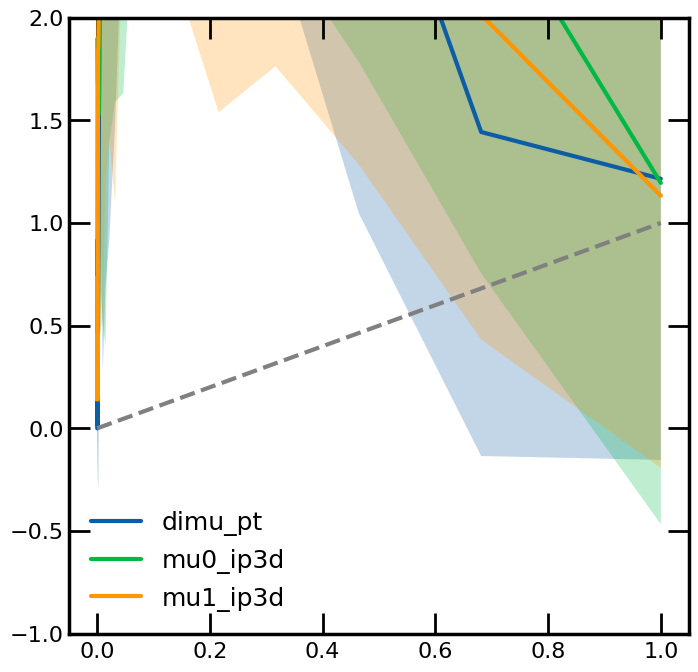

In [169]:

feature_SIGs = {}

flip_features = [False, True, True] 
for (i, feature) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d"]):
# for (i, feature) in enumerate(["dimu_pt"]):
    print(feature)
    feature_SIGs[feature] = feature_cut_ROCS(feature, test_data_dict, scaler, fit_type, f"{particle_type}{train_data_id_title} ({feature} on {train_data_id_title})\n quintic", SB_left, SR_left, SR_right, SB_right, flip = flip_features[i], index = i)
    plt.plot(fpr_thresholds_finegrained, feature_SIGs[feature].mean(axis = 1), label = feature)

    with open(f"{plot_data_dir}{data_prefix}_significances_{feature}_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
        pickle.dump(feature_SIGs[feature], ofile)

    # band 
    feature_TPRS_mean = feature_SIGs[feature].mean(axis = 1)
    feature_TPRS_std = feature_SIGs[feature].std(axis = 1)

    # feature_FPRS_mean = feature_FPRs[feature].mean(axis = 1)
    # feature_FPRS_std = feature_FPRs[feature].std(axis = 1)

    plt.fill_between(fpr_thresholds_finegrained, feature_TPRS_mean-feature_TPRS_std, feature_TPRS_mean+feature_TPRS_std, alpha = 0.25)

plt.ylim(-1, 2)
plt.plot([0, 1], [0, 1], linestyle = "--", color = "grey")

plt.legend()



In [170]:
# Add the ordinary TPR, FPR, ROC, SIC to dictionary with key "CATHODE"
feature_SIGs["CATHODE"] = significances


In [171]:
print(feature_SIGs["dimu_pt"])

[[0.81055808 2.89300636 1.23574748 ... 3.12734765 2.63494455 0.        ]
 [2.48819703 3.55030058 2.53689339 ... 1.55080132 4.20231742 0.        ]
 [0.10291368 4.99411856 4.8815611  ... 3.50738205 6.025455   1.27731051]
 ...
 [0.13118319 0.52549088 0.         ... 0.         0.         0.60062818]
 [0.1131126  0.38224304 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


[0.81239577 1.62045158 2.8745063  2.05197167 3.5058477  1.69726342
 1.52030945 5.07847995 5.8936203  8.51924264 8.48052746 8.4895444
 8.5394708  6.52985104 5.45145772 3.48733761 4.19496524 3.18523421
 2.4576946  3.14740407 2.39415277 0.40129203 0.40129203 0.15621512
 0.15621512]


<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:48: SyntaxWarning: invalid escape sequence '\P'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:48: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_1591802/819059693.py:29: SyntaxWarning: invalid escape sequence '\p'
  plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
/tmp/ipykernel_1591802/819059693.py:48: SyntaxWarning: invalid escape sequence '\P'
  ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


(0.0, 20.0)

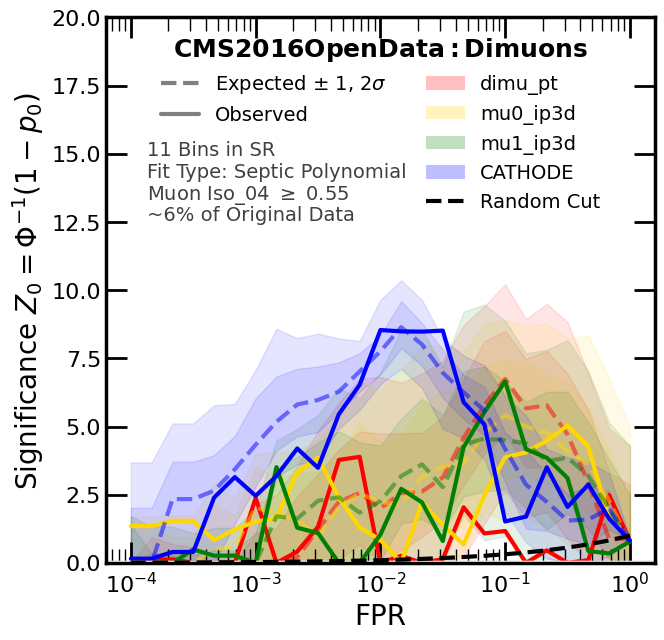

In [172]:
def get_median_percentiles(x_array):
    
    x_median = np.median(x_array, axis = 1)
    x_lower = np.percentile(x_array, 16, axis = 1)
    x_upper = np.percentile(x_array, 84, axis = 1)

    x_2lower = np.percentile(x_array, 2.5, axis = 1)
    x_2upper = np.percentile(x_array, 97.5, axis = 1)

    return x_median, x_lower, x_upper, x_2lower, x_2upper


# FPR Variant of SIC
fig, ax = newplot("full", use_tex = latex_flag)
colors = ["red", "gold", "green", "blue"]
for (i, key) in enumerate(feature_SIGs.keys()):


    SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs[key][:,1:])
    SIG_observed = feature_SIGs[key][:,0]

    ax.plot(fpr_thresholds_finegrained, SIG_observed, color = colors[i])

    ax.plot(fpr_thresholds_finegrained, SIG_median, color = colors[i], linestyle = "dashed", alpha = 0.5)
    ax.fill_between(fpr_thresholds_finegrained, SIG_lower, SIG_upper, alpha = 0.1, color = colors[i])
    ax.fill_between(fpr_thresholds_finegrained, SIG_2lower, SIG_2upper, alpha = 0.1, color = colors[i])

# Artificially make a legend
plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
plt.axhline(0, color = "Grey", label = "Observed")

# add dummy white space to legend so that column 1 has the same height as column 2
num_features = len(feature_SIGs.keys()) 
for i in range(num_features):
    plt.axhline(0, color = "white", label = " ")


# Add the keys in a seperate column with filled color
for (i, key) in enumerate(feature_SIGs.keys()):
    ax.hist([-1], color = colors[i], alpha = 0.25, label = key, histtype = "stepfilled")


print(feature_SIGs["CATHODE"][:,0])


ax.plot(fpr_thresholds_finegrained, fpr_thresholds_finegrained/np.sqrt(fpr_thresholds_finegrained), linestyle = "dashed", color = "black", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


line1 = f"{num_bins_SR -1 } Bins in SR"
line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
line3 = r"Muon Iso_04 $\geq$ 0.55"
line4 = r"~6% of Original Data"

starting_x = 0.075
starting_y = 0.775
delta_y = 0.04
text_alpha = 0.75
ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)


legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"

plt.legend(title = legend_title, loc = "upper center", ncol = 2, fontsize = 14)
plt.xscale("log")
plt.ylim(0.0, 20)
# plt.yscale("log")

# ax.plot(FPR_median, SIC_median, color = "black", label = r"CATHODE")
# ax.fill_between(FPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = "black")
# ax.plot(FPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey", label = "Random Cut")
# ax.set_xlabel("FPR")
# ax.set_ylabel("Signifance Improvement")

# legend_title = "Original Signifiance = {###}"
# plt.legend(title = legend_title, loc = "upper right")
# plt.xscale("log")
# plt.ylim(0, 6)